In [1]:
import numpy as np
import matplotlib.pyplot as plt

class perceptron:
    def __init__(self,n,beta,bias,name='default'):
        pesos      = beta*np.ones(n)
        pesos      = np.concatenate((pesos,np.array([bias])))
        self.n     = n
        self.name  = name
        self.pesos = pesos
    
    def Evaluar(self,entradas):
        ##########################################################################
        #   La función de activación del perceptron será la función "Sigmoide"   #
        #                      sigmoide = 1 / ( 1 + e^{-S} )                     #
        ##########################################################################
        S     = self.pesos.dot(entradas)
        sigma = 1 / ( 1 + np.exp(-S) )
        return sigma

class NeuralNet:
    def __init__(self,layersShape,initialize,bias,InSize,InAll,name='Perc'):
        size  = len(layersShape)
        Net   = np.resize( np.array( [] , dtype = perceptron), size)
        count = 0
        nIn   = InSize
        Grad  = [ ]
        for i,nPerc in enumerate(layersShape):
            layer  = [ ]
            ini    = np.random.rand(nPerc) if initialize == 'random' else [initialize]*nPerc
            Bias   = np.random.rand(nPerc) if bias == 'random' else [bias]*nPerc
            Gradi  = [ ]
            for j in range(nPerc):
                layer += [perceptron(nIn,ini[j],Bias[j],f'{name}_layer{i}_perc{count}')]
                count += 1
                Gradij = [0]*(nIn + 1)
                Gradi += [ Gradij ]
            Grad  += [ Gradi ]
            Net[i] = layer
            nIn    = nPerc + InSize if ( InAll and i == ( size - 2 ) ) else nPerc
        self.layers      = Net
        self.layersShape = layersShape
        self.nlayers     = size
        self.nNodes      = count
        self.InAll       = InAll
        self.name        = name
        self.InSize      = InSize
        self.Grad        = Grad
    
    def Evaluar(self,In):
        shape = self.layersShape
        size  = self.nlayers
        Net   = self.layers
        InAll = self.InAll
        IN    = [In]
        OUT   = []
        for i,nPerc in enumerate(shape):
            Outi  = []
            IN[i] = IN[i] + [1]  # Se agrega "1" al vector de entrada, que representa la entrada para el "bias"
            for j in range(nPerc):
                Outi += [Net[i][j].Evaluar(IN[i])]
            IN   += [Outi + In] if ( InAll and i == ( size - 2 ) ) else [Outi]
            OUT  += [Outi]
        self.layersOut = OUT
        self.layersIn  = IN
        return OUT[-1]
    
    def Train(self,epocas,lr,DataSet,BatchSize=1):
        print('\n\n'+'\033[1m' + f'Entrenamiento de la red {self.name}' + '\033[0m' + '\n')
        MSE   = []
        Conv  = False
        Convi = 0
        Grad  = self.Grad
        for i in range(epocas):
            MSEi   = 0
            nBatch = 0
            conv   = []
            k      = 0
            for j,[In,Out] in enumerate(DataSet):
                yd      = np.array(Out)
                y       = np.array(self.Evaluar(In))
                Grad    = self.Backpropagation(yd,Grad)
                nBatch += 1
                if nBatch == BatchSize:
                    self.UpdateWeights(nBatch,lr,Grad)
                    nBatch = 0
                    k      = j
                    Grad   = [ [ [ 0 for c in b ] for b in a ] for a in Grad]
                elif j == len(DataSet)-1:
                    self.UpdateWeights(nBatch,lr,Grad)
                    Grad   = [ [ [ 0 for c in b ] for b in a ] for a in Grad]
                error   = np.linalg.norm(yd - y)
                conv   += [True] if error <= 0.05 else [False]
                MSEi   += 0.5*error**2
            # Verificar si cumple el criterio de convergencia de error <= 0.1
            if not Conv:
                Conv = True
                for co in conv:
                    Conv = Conv and co
                if Conv:
                    print(f'Convergencia en \033[1mepoca {i}\033[0m')
                    Convi = i
                    break
            MSE   += [MSEi/j]
        if not Conv:
            print(f'No convergencia en {epocas} epocas')
        self.Grad = Grad
        return MSE, Convi
    
    def Backpropagation(self,yd,grad):
        #a       = 1/nbatch
        shape   = self.layersShape
        nlayers = self.nlayers
        Net     = self.layers
        InAll   = self.InAll
        Out     = self.layersOut
        In      = self.layersIn
        
        #########################################
        # Obtener los valores "delta" de la red #
        #########################################
        
        Grad   = grad
        delta  = [ [ ] ]*nlayers
        Err    = np.array(yd) - np.array(Out[-1])
        error  = [*Err]
        for i,nPerc in reversed(list(enumerate(shape))): # Iterar sobre las capas de la red
            deltai = []
            errori = []
            for j in range(nPerc): # Iterar sobre las "neuronas" de la capa i
                deltaij  = error[j]*Out[i][j]*(1-Out[i][j])
                deltai  += [deltaij]
            delta[i] = deltai
            for k in range(Net[i][0].pesos.size-1): # Iterar sobre cada uno de los pesos de la neurona ij
                errorij = 0
                for j in range(nPerc): # Iterar sobre las "neuronas" de la capa i
                    errorij += deltai[j]*Net[i][j].pesos[k]
                errori += [errorij]
            error  = errori
        for i,nPerc in enumerate(shape):
            for j in range(nPerc):
                for k in range(Net[i][j].pesos.size):
                    #Net[i][j].pesos[k] += a*lr*delta[i][j]*In[i][k]
                    Grad[i][j][k] += delta[i][j]*In[i][k]
        self.layers = Net
        return Grad
    
    def UpdateWeights(self,Batch,lr,Grad):
        a     = (1/Batch)
        Net   = self.layers
        In    = self.layersIn
        shape = self.layersShape
        
        ##############################################
        #       Actualizar los pesos de la red       #
        ##############################################
        for i,nPerc in enumerate(shape):
            for j in range(nPerc):
                for k in range(Net[i][j].pesos.size):
                    Net[i][j].pesos[k] += a*lr*Grad[i][j][k]
        self.layers = Net

nn************************************************************************************************************
************************************************************************************************************
*************************        Orden de entrenamiento 1        *************************
************************************************************************************************************
************************************************************************************************************
**************************************************************************************************
Evaluación de las redes neuronales para la compuerta logica "And", "Or" y "Xor" sin entrenamiento
**************************************************************************************************
         And                   Or               Xor
1: [0, 0] ... 0.8   |   [0, 0] ... 0.8   |   [0, 0] ... 0.8
2: [0, 1] ... 0.9   |   [0, 1] ... 0.9   |   [0, 1] ... 0.9
3

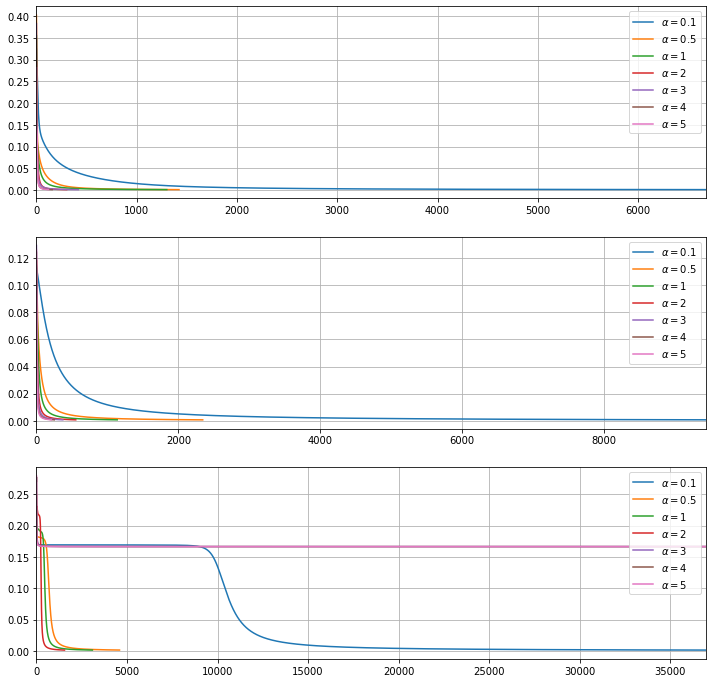


***********************************
Entrenamiento de las redes
***********************************
Orden de dataset: 1
Tasa de aprendizaje: 0.1
Peso inicial: random
Bias: 1
Epocas de entrenamiento: 50000
Batch: 2


Entrenamiento de la red And

Convergencia en epoca 21104


Entrenamiento de la red Or

Convergencia en epoca 22163


Entrenamiento de la red Xor

Convergencia en epoca 45869

********************************************************************************************************
Evaluación de las redes para la compuerta logica "And", "Or" y "Xor" con entrenamiento
********************************************************************************************************
         And                   Or               Xor
1: [0, 0] ... 0.0   |   [0, 0] ... 0.0   |   [0, 0] ... 0.0
2: [0, 1] ... 0.0   |   [0, 1] ... 1.0   |   [0, 1] ... 1.0
3: [1, 0] ... 0.0   |   [1, 0] ... 1.0   |   [1, 0] ... 1.0
4: [1, 1] ... 1.0   |   [1, 1] ... 1.0   |   [1, 1] ... 0.0

*******************

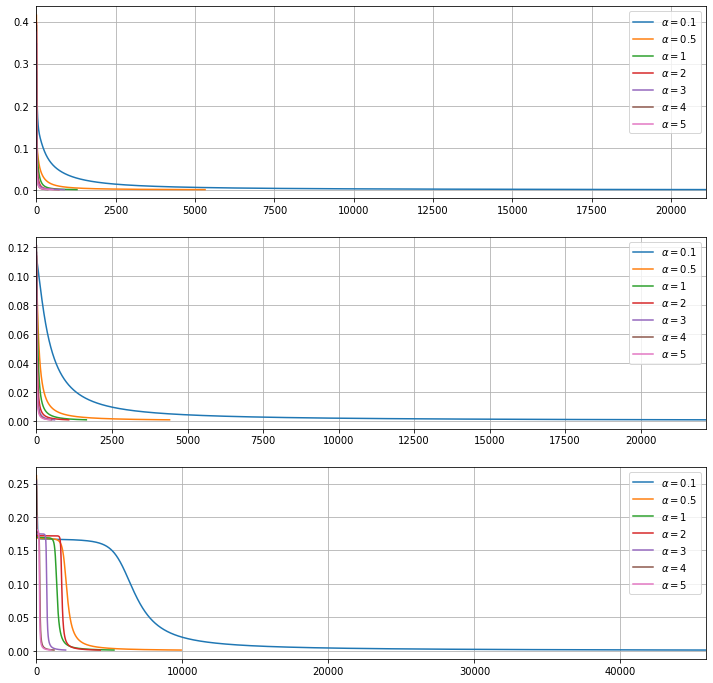


***********************************
Entrenamiento de las redes
***********************************
Orden de dataset: 1
Tasa de aprendizaje: 0.1
Peso inicial: random
Bias: 1
Epocas de entrenamiento: 50000
Batch: 4


Entrenamiento de la red And

Convergencia en epoca 27783


Entrenamiento de la red Or

Convergencia en epoca 44248


Entrenamiento de la red Xor

No convergencia en 50000 epocas

********************************************************************************************************
Evaluación de las redes para la compuerta logica "And", "Or" y "Xor" con entrenamiento
********************************************************************************************************
         And                   Or               Xor
1: [0, 0] ... 0.0   |   [0, 0] ... 0.0   |   [0, 0] ... 0.1
2: [0, 1] ... 0.0   |   [0, 1] ... 1.0   |   [0, 1] ... 0.9
3: [1, 0] ... 0.0   |   [1, 0] ... 1.0   |   [1, 0] ... 0.9
4: [1, 1] ... 1.0   |   [1, 1] ... 1.0   |   [1, 1] ... 0.1

***************

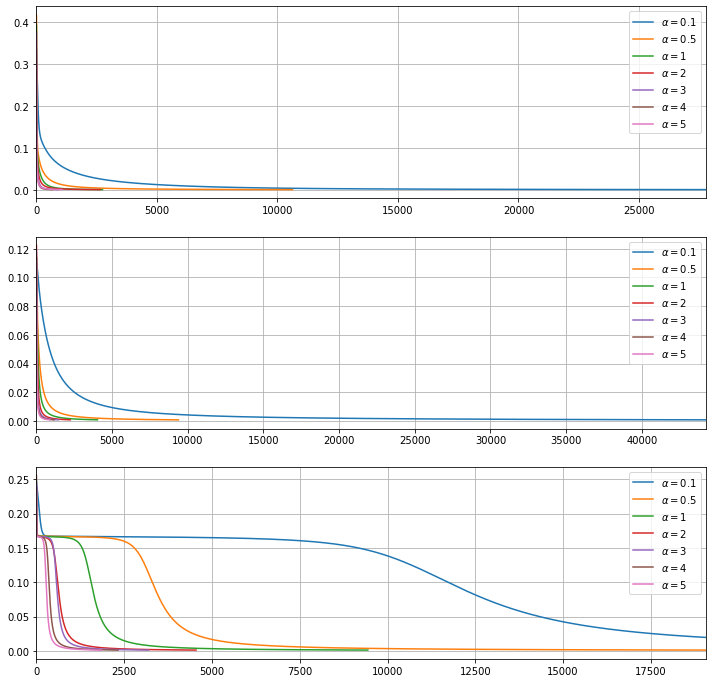

nn************************************************************************************************************
************************************************************************************************************
*************************        Orden de entrenamiento 2        *************************
************************************************************************************************************
************************************************************************************************************
**************************************************************************************************
Evaluación de las redes neuronales para la compuerta logica "And", "Or" y "Xor" sin entrenamiento
**************************************************************************************************
         And                   Or               Xor
1: [1, 1] ... 1.0   |   [1, 1] ... 1.0   |   [1, 1] ... 0.9
2: [1, 0] ... 0.9   |   [1, 0] ... 0.9   |   [1, 0] ... 0.8
3

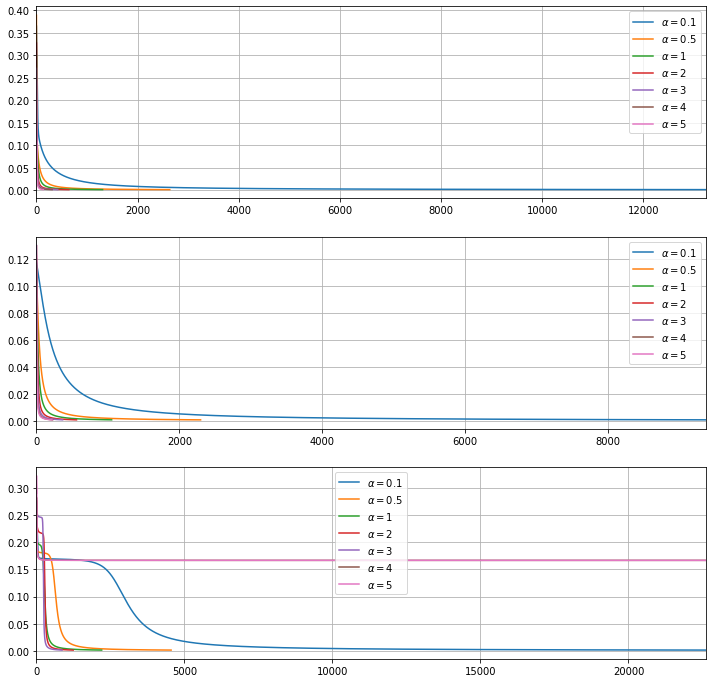


***********************************
Entrenamiento de las redes
***********************************
Orden de dataset: 2
Tasa de aprendizaje: 0.1
Peso inicial: random
Bias: 1
Epocas de entrenamiento: 50000
Batch: 2


Entrenamiento de la red And

Convergencia en epoca 13596


Entrenamiento de la red Or

Convergencia en epoca 16298


Entrenamiento de la red Xor

No convergencia en 50000 epocas

********************************************************************************************************
Evaluación de las redes para la compuerta logica "And", "Or" y "Xor" con entrenamiento
********************************************************************************************************
         And                   Or               Xor
1: [1, 1] ... 1.0   |   [1, 1] ... 1.0   |   [1, 1] ... 0.1
2: [1, 0] ... 0.0   |   [1, 0] ... 1.0   |   [1, 0] ... 1.0
3: [0, 1] ... 0.0   |   [0, 1] ... 1.0   |   [0, 1] ... 1.0
4: [0, 0] ... 0.0   |   [0, 0] ... 0.0   |   [0, 0] ... 0.0

***************

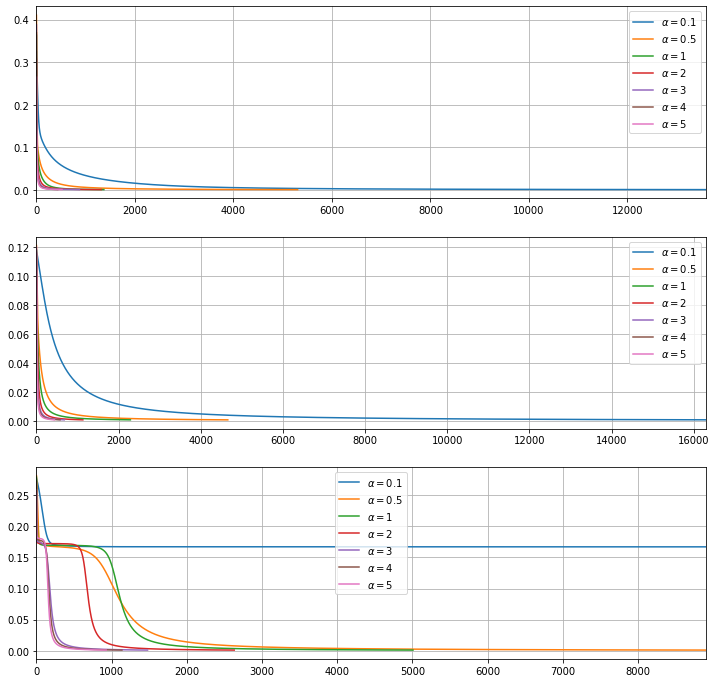


***********************************
Entrenamiento de las redes
***********************************
Orden de dataset: 2
Tasa de aprendizaje: 0.1
Peso inicial: random
Bias: 1
Epocas de entrenamiento: 50000
Batch: 4


Entrenamiento de la red And

No convergencia en 50000 epocas


Entrenamiento de la red Or

Convergencia en epoca 47423


Entrenamiento de la red Xor

No convergencia en 50000 epocas

********************************************************************************************************
Evaluación de las redes para la compuerta logica "And", "Or" y "Xor" con entrenamiento
********************************************************************************************************
         And                   Or               Xor
1: [1, 1] ... 0.9   |   [1, 1] ... 1.0   |   [1, 1] ... 0.1
2: [1, 0] ... 0.0   |   [1, 0] ... 1.0   |   [1, 0] ... 0.9
3: [0, 1] ... 0.0   |   [0, 1] ... 1.0   |   [0, 1] ... 0.9
4: [0, 0] ... 0.0   |   [0, 0] ... 0.0   |   [0, 0] ... 0.1

***********

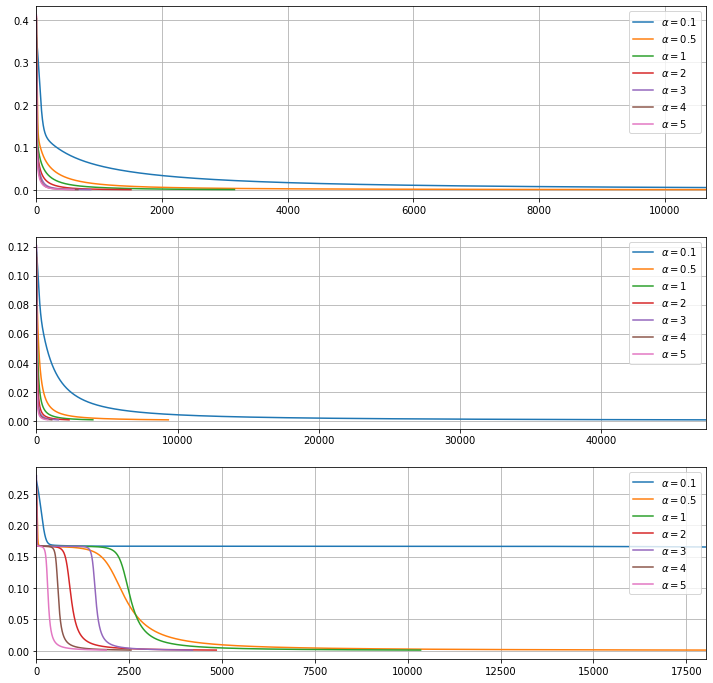

nn************************************************************************************************************
************************************************************************************************************
*************************        Orden de entrenamiento 3        *************************
************************************************************************************************************
************************************************************************************************************
**************************************************************************************************
Evaluación de las redes neuronales para la compuerta logica "And", "Or" y "Xor" sin entrenamiento
**************************************************************************************************
         And                   Or               Xor
1: [0, 0] ... 0.8   |   [0, 0] ... 0.8   |   [0, 0] ... 0.8
2: [1, 1] ... 0.9   |   [1, 1] ... 0.9   |   [1, 1] ... 1.0
3

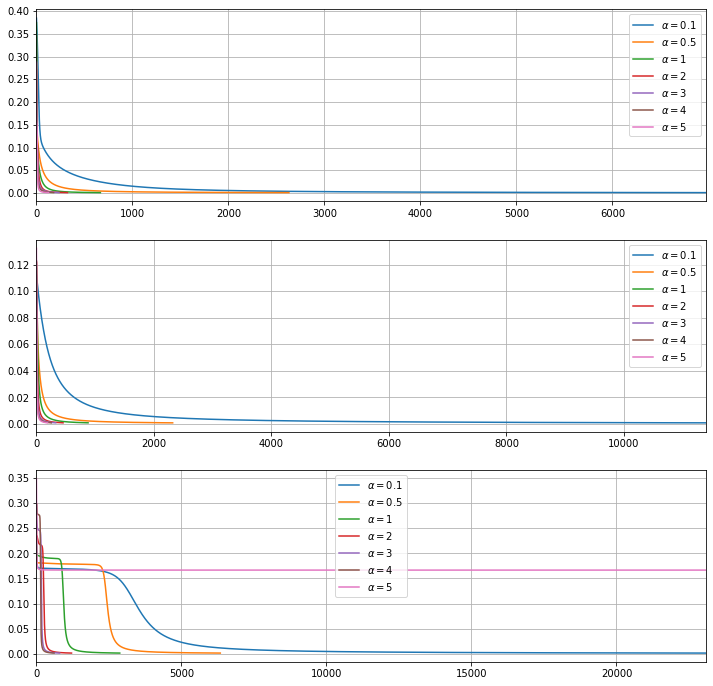


***********************************
Entrenamiento de las redes
***********************************
Orden de dataset: 3
Tasa de aprendizaje: 0.1
Peso inicial: random
Bias: 1
Epocas de entrenamiento: 50000
Batch: 2


Entrenamiento de la red And

Convergencia en epoca 26484


Entrenamiento de la red Or

Convergencia en epoca 17008


Entrenamiento de la red Xor

Convergencia en epoca 44951

********************************************************************************************************
Evaluación de las redes para la compuerta logica "And", "Or" y "Xor" con entrenamiento
********************************************************************************************************
         And                   Or               Xor
1: [0, 0] ... 0.0   |   [0, 0] ... 0.0   |   [0, 0] ... 0.0
2: [1, 1] ... 1.0   |   [1, 1] ... 1.0   |   [1, 1] ... 0.0
3: [0, 1] ... 0.0   |   [0, 1] ... 1.0   |   [0, 1] ... 1.0
4: [1, 0] ... 0.0   |   [1, 0] ... 1.0   |   [1, 0] ... 1.0

*******************

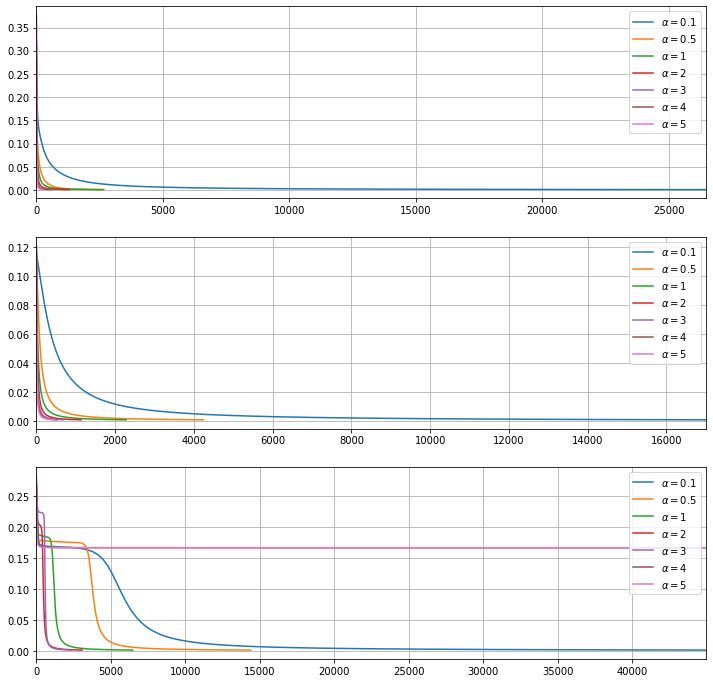


***********************************
Entrenamiento de las redes
***********************************
Orden de dataset: 3
Tasa de aprendizaje: 0.1
Peso inicial: random
Bias: 1
Epocas de entrenamiento: 50000
Batch: 4


Entrenamiento de la red And

Convergencia en epoca 25192


Entrenamiento de la red Or

Convergencia en epoca 45721


Entrenamiento de la red Xor

No convergencia en 50000 epocas

********************************************************************************************************
Evaluación de las redes para la compuerta logica "And", "Or" y "Xor" con entrenamiento
********************************************************************************************************
         And                   Or               Xor
1: [0, 0] ... 0.0   |   [0, 0] ... 0.0   |   [0, 0] ... 0.5
2: [1, 1] ... 1.0   |   [1, 1] ... 1.0   |   [1, 1] ... 0.5
3: [0, 1] ... 0.0   |   [0, 1] ... 1.0   |   [0, 1] ... 0.5
4: [1, 0] ... 0.0   |   [1, 0] ... 1.0   |   [1, 0] ... 0.5

***************

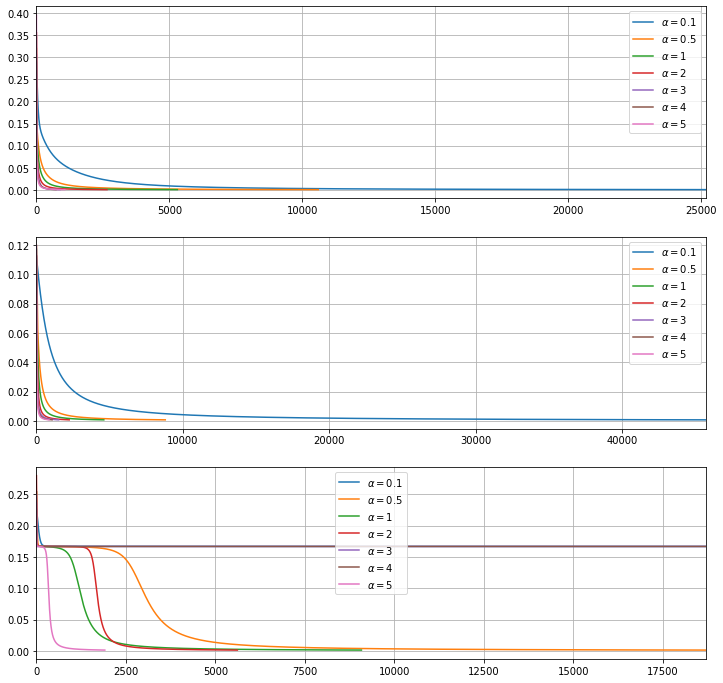

In [5]:
lr     = [0.1,0.5,1,2,3,4,5]
epocas = 50000
wi     = 'random'
bias   = 1
conAll = True
Batchs = [1,2,4]
shape  = (1,1) # Forma de la red (capas y neuronas por cada capa)

# Leyendas para graficas de aprendizaje
PlotLegend = [r'$\alpha=0.1$',r'$\alpha=0.5$',r'$\alpha=1$',r'$\alpha=2$',r'$\alpha=3$',r'$\alpha=4$',r'$\alpha=5$',]

####################################################################
###    Generar los dataset para el entrenamiento de las redes    ###
####################################################################
IN           = [[0 , 0] , [0 , 1] , [1 , 0] , [1 , 1]]
Dataset1_And = [[IN[0], [0]] , [IN[1], [0]] , [IN[2], [0]] , [IN[3], [1]]]
Dataset1_Or  = [[IN[0], [0]] , [IN[1], [1]] , [IN[2], [1]] , [IN[3], [1]]]
Dataset1_Xor = [[IN[0], [0]] , [IN[1], [1]] , [IN[2], [1]] , [IN[3], [0]]]
Dataset2_And = [[IN[3], [1]] , [IN[2], [0]] , [IN[1], [0]] , [IN[0], [0]]]
Dataset2_Or  = [[IN[3], [1]] , [IN[2], [1]] , [IN[1], [1]] , [IN[0], [0]]]
Dataset2_Xor = [[IN[3], [0]] , [IN[2], [1]] , [IN[1], [1]] , [IN[0], [0]]]
Dataset3_And = [[IN[0], [0]] , [IN[3], [1]] , [IN[1], [0]] , [IN[2], [0]]]
Dataset3_Or  = [[IN[0], [0]] , [IN[3], [1]] , [IN[1], [1]] , [IN[2], [1]]]
Dataset3_Xor = [[IN[0], [0]] , [IN[3], [0]] , [IN[1], [1]] , [IN[2], [1]]]

Dataset  = []
Dataset += [ [ Dataset1_And , Dataset1_Or , Dataset1_Xor ] ]
Dataset += [ [ Dataset2_And , Dataset2_Or , Dataset2_Xor ] ]
Dataset += [ [ Dataset3_And , Dataset3_Or , Dataset3_Xor ] ]

for j,[Dataset_And , Dataset_Or , Dataset_Xor] in enumerate(Dataset):
    print(f'\1n\1n************************************************************************************************************')
    print(f'************************************************************************************************************')
    print(f'*************************        \033[1mOrden de entrenamiento {j+1}\033[0m        *************************')
    print(f'************************************************************************************************************')
    print(f'************************************************************************************************************')

    ######################################################################
    ###                  Crear las redes neuronales                    ###
    ###           Evaluación inicial de las redes neuronales           ###
    ######################################################################

    And = NeuralNet(shape,wi,bias,2,conAll,'And')
    Or  = NeuralNet(shape,wi,bias,2,conAll,'Or')
    Xor = NeuralNet(shape,wi,bias,2,conAll,'Xor')

    print('**************************************************************************************************')
    print(f'Evaluación de las redes neuronales para la compuerta logica "And", "Or" y "Xor" sin entrenamiento')
    print('**************************************************************************************************')
    print('\033[1m' + f'         And                   Or               Xor' + '\033[0m')
    for i,[In,Out] in enumerate(Dataset_And):
        a  = And.Evaluar(In)
        b  = Or.Evaluar(In)
        c  = Xor.Evaluar(In)
        print(f'{i+1}: {In} ... {a[0]:.1f}   |   {In} ... {b[0]:.1f}   |   {In} ... {c[0]:.1f}')


    #####################################################################
    ###             Entrenamiento de las redes neuronales             ###
    #####################################################################
    for Batch in Batchs:
        # Almacenar la epoca en la que converge la red en su entrenamiento
        And_Conv = [ ]
        Or_Conv  = [ ]
        Xor_Conv = [ ]
        MSE_And  = [ ]
        MSE_Or   = [ ]
        MSE_Xor  = [ ]
        for lri in lr:
            And = NeuralNet(shape,wi,bias,2,conAll,'And')
            Or  = NeuralNet(shape,wi,bias,2,conAll,'Or')
            Xor = NeuralNet(shape,wi,bias,2,conAll,'Xor')

            print(f'\n***********************************\n\033[1mEntrenamiento de las redes\033[0m\n***********************************')
            print(f'Orden de dataset: {j+1}\nTasa de aprendizaje: {lri}\nPeso inicial: {wi}\nBias: {bias}\nEpocas de entrenamiento: {epocas}\nBatch: {Batch}')

            ###############################################################
            #  Backpropagation para generar la compuerta lógica And y Or  #
            ###############################################################

            MSE_Andi,And_Convi = And.Train(epocas,lri,Dataset_And,Batch)
            MSE_Ori,Or_Convi   = Or.Train(epocas,lri,Dataset_Or,Batch)
            MSE_Xori,Xor_Convi = Xor.Train(epocas,lri,Dataset_Xor,Batch)

            MSE_And  += [MSE_Andi]
            MSE_Or   += [MSE_Ori]
            MSE_Xor  += [MSE_Xori]
            And_Conv += [And_Convi]
            Or_Conv  += [Or_Convi]
            Xor_Conv += [Xor_Convi]

            print('\n********************************************************************************************************')
            print(f'Evaluación de las redes para la compuerta logica "And", "Or" y "Xor" con entrenamiento')
            print('********************************************************************************************************')
            print('\033[1m' + f'         And                   Or               Xor' + '\033[0m')
            for i,[In,Out] in enumerate(Dataset_And):
                a  = And.Evaluar(In)
                b  = Or.Evaluar(In)
                c  = Xor.Evaluar(In)
                print(f'{i+1}: {In} ... {a[0]:.1f}   |   {In} ... {b[0]:.1f}   |   {In} ... {c[0]:.1f}')

        plt.figure(figsize=(12,12))
        plt.subplot(3,1,1)
        for plot in MSE_And:
            plt.plot(plot)
            plt.legend(PlotLegend)
        plt.grid()
        plt.xlim((0,max(And_Conv)))
        plt.subplot(3,1,2)
        for plot in MSE_Or:
            plt.plot(plot)
            plt.legend(PlotLegend)
        plt.grid()
        plt.xlim((0,max(Or_Conv)))
        plt.subplot(3,1,3)
        for plot in MSE_Xor:
            plt.plot(plot)
            plt.legend(PlotLegend)
        plt.grid()
        plt.xlim((0,max(Xor_Conv)))
        plt.savefig(f'Training Batch {Batch} Orden {j+1}.png')
        plt.show()